In [1]:
#this chunk is necessary for importing correctly NeuralTree class in correct way
import os
import sys
sys.path.insert(0, os.path.abspath('./model'))

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import pickle as pkl

from sklearn.decomposition import PCA #features extraction
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.tree import plot_tree #visualize a decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.neighbors import KNeighborsClassifier #K-Nearest Neighbors
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay #model evaluation metrics
from sklearn.preprocessing import StandardScaler #data normalization

from scipy.stats import entropy

from imblearn.over_sampling import SMOTE #package for using SMOTE for balance dataset

from model.NeuralTree import NeuralTree

%matplotlib inline

In [7]:
DATA_PATH_MALWARE = "../csv/malware"
DATA_PATH_GOODWARE = "../csv/goodware"
DATASET_PATH = "../csv"
EXPORTED_MODEL = "../exported_model"
col_names = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp',
             'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
             'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
             'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
             'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
             'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
             'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
             'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
             'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
             'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
             'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
             'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
             'Fwd Header Length_1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
             'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
             'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
             'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
             'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

# COSTRUZIONE DATASET
* avendo il dataset scomposto in molteplici *csv* vado a unirli in uno singolo, almeno per un primo momento, distinguendo i files contenti traffico benevolo e malevolo;
* rinomino i campi secondo le seguenti caratteristiche:
    * parole separate da spazio anzichè da '_';
    * prima lettera di ogni parola sarà maiuscola.
* a ogni record gli accosto un codice che identifica univocamnete il Sample che ha la seguete struttura: *{G,M}\_N*, dove:
    * **G** ed **M** indicano rispettivamente goodware e malware;
    * **N** indica il numero del sample preso in considerazione

In [38]:
def __change_name_and_order(data):
    new_names = list()
    #data = pd.read_csv(csv_path)

    for col in data.columns:
        new_name = col.split('_')
        new_names.append(" ".join(new_name).title()) #funzione title trasforma la prima lettera di ogni parola in maiuscolo (capitalizza)
        #print(new_name)
    data.columns = new_names

    #riordinamento delle features
    data = data.loc[:, ["Src Ip", "Src Port", "Dst Ip", "Dst Port", "Protocol", "Timestamp", "Flow Duration", "Tot Fwd Pkts",
           "Tot Bwd Pkts", "Totlen Fwd Pkts", "Totlen Bwd Pkts", "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean",
           "Fwd Pkt Len Std", "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std", "Flow Byts S",
           "Flow Pkts S", "Flow Iat Mean", "Flow Iat Std", "Flow Iat Max", "Flow Iat Min", "Fwd Iat Tot", "Fwd Iat Mean",
           "Fwd Iat Std", "Fwd Iat Max", "Fwd Iat Min", "Bwd Iat Tot", "Bwd Iat Mean", "Bwd Iat Std", "Bwd Iat Max",
           "Bwd Iat Min","Fwd Psh Flags", "Bwd Psh Flags", "Fwd Urg Flags", "Bwd Urg Flags",
           "Fwd Header Len", "Bwd Header Len", "Fwd Pkts S", "Bwd Pkts S", "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean",
           "Pkt Len Std", "Pkt Len Var", "Fin Flag Cnt", "Syn Flag Cnt", "Rst Flag Cnt", "Psh Flag Cnt", "Ack Flag Cnt",
           "Urg Flag Cnt", "Cwe Flag Count", "Ece Flag Cnt", "Down Up Ratio", "Pkt Size Avg", "Fwd Seg Size Avg",
           "Bwd Seg Size Avg", "Fwd Header Len", "Fwd Byts B Avg", "Fwd Pkts B Avg", "Fwd Blk Rate Avg", "Bwd Byts B Avg",
           "Bwd Pkts B Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts", "Subflow Fwd Byts", "Subflow Bwd Pkts",
           "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Act Data Pkts", "Fwd Seg Size Min",
           "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"]]

    return data

def csv_merging(dest_df, files_path):
    id_num = 1

    for csv_file in os.listdir(files_path):
        if not (csv_file == ".DS_Store" or "Monday-WorkingHours" in csv_file):
            print(csv_file)
            data = pd.read_csv(f"{files_path}/{csv_file}", encoding='utf-8', sep=',', engine='python')

            data = __change_name_and_order(data)

            if "malware" in files_path:
                data["Sample ID"] = f"M_{id_num}"
            else:
                data["Sample ID"] = f"G_{id_num}"
            id_num += 1

            dest_df = pd.concat([dest_df, data])

    print('\n')

    return dest_df

In [ ]:
csv_merging(pd.DataFrame(), DATA_PATH_MALWARE).to_csv(f"{DATASET_PATH}/malware.csv", index=False)
csv_merging(pd.DataFrame(), DATA_PATH_GOODWARE).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

Per problemi lo script mostrato sopra per *Monday-WorkingHours.csv* non funzione quindi procedo a una procedura ad hoc.

In [40]:
goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)
monday = pd.read_csv(f"{DATA_PATH_GOODWARE}/Monday-WorkingHours.csv", low_memory=False)

monday["Sample ID"] = "G_51"
monday.columns = goodware.columns

pd.concat([goodware, monday]).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

del goodware, monday

* eseguo labelling dei dati (MALWARE/BENIGN)

In [41]:
for csv in os.listdir(DATASET_PATH):
    if csv.endswith(".csv"):
        df = pd.read_csv(f"{DATASET_PATH}/{csv}", low_memory=False)

        if "malware" in csv:
            df['Label'] = "MALWARE"
        else:
            df['Label'] = "BENIGN"

        df.to_csv(f"{DATASET_PATH}/{csv}", index=False)

* unisco i due dataset creati al primo punto, in un singolo dataset

# NORMALIZZAZIONE DATASET
* accstare porta e IP sorgente (analogamete per la destinarione);
* eliminare punto da stringa che indica l'IP;
* cambiare tipi delle features, dove necessario:

Ultimi due passi sono necessari perchè algoritmi di ML accettano solo valori numerici.

In [47]:
def normalize_ip(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)

    data.iloc[:, 0] = data.iloc[:, 0].map(lambda ip : __string_to_integer_ip(ip))
    data.iloc[:, 2] = data.iloc[:, 2].map(lambda ip : __string_to_integer_ip(ip))

    data.to_csv(csv_path, index=False)

def __string_to_integer_ip(ip):
    if not isinstance(ip, int):
        splitted_ip = ip.split('.')

        return "".join(splitted_ip)
    return ip

def change_features_type(csv_path, features_types):
    data = pd.read_csv(csv_path, low_memory=False)

    for i in range(data.shape[1]):
        data.iloc[:, i].astype(features_types[i])

    data.to_csv(csv_path, index=False)

Converto il formato stringa dell'indirizzo IP (aaa.bbb.ccc.ddd) in un formato comprensibile all'algoritmo di machine learning, cioè un intero nel seguente formato **aaabbbcccddd**.

In [48]:
normalize_ip(f"{DATASET_PATH}/malware.csv")
normalize_ip(f"{DATASET_PATH}/goodware.csv")

Unione dataset goodware e malware in un unico file in formato csv

In [45]:
df_malware = pd.read_csv(f"{DATASET_PATH}/malware.csv", low_memory=False)
df_goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)

pd.concat([df_malware, df_goodware]).to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

del df_malware, df_goodware

In [46]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)

Convertire i timestamp in formato numerico

In [47]:
unix_ts = pd.to_datetime(dataset['Timestamp']).view('int64')

dataset['Timestamp'] = unix_ts

del unix_ts

Creare flowID (IPscr, portScr, IDdst, portDst, Protocollo)

In [48]:
dataset['FlowID'] = dataset['Src Ip'].map(str) + "_"+ dataset['Src Port'].map(str) + "_" + dataset['Dst Ip'].map(str) + "_"  + dataset['Dst Port'].map(str) + "_" + dataset['Protocol'].map(str)

dataset.set_index('FlowID').to_csv(f"{DATASET_PATH}/dataset.csv")

Convertire le etichette in formato numerico: (MALWARE -> 1.0 e GOODWARE -> 0.0)

In [49]:
dataset['Label'].replace(["MALWARE", "BENIGN"], [1.0, 0.0], inplace=True)

dataset.to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

In [50]:
del dataset

# FEATURES EXTRACTION

In [5]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)

In linea generale il processo di feature extraction consiste nel scegliere le migliori features riducendo così la dimensionalità del dataset per fare ciò va do a sfruttare la **PCA (Principal Componenet Analyis)** fornita da *scikit-learn*.

Prima di effettuare la features extraction sopra descritta necessito di effettuare un processo di "bonifica" del dataset.

In [ ]:
dataset[dataset.isin(['78,125'])].stack()

*Flow Pkts S* in linea generale contiene valori *double*, ma nel caso sopra citato contiene una stringa; per questo motivo vado a convertirlo in double.

In [6]:
dataset.at[1642652, 'Flow Pkts S'] = 78.125

dataset.loc[1642652, 'Flow Pkts S']

78.125

Controllo se sono presenti valori *NaN* e *Inf*

In [7]:
#conteggio valori NaN
dataset.isnull().sum().sum()

89

In [8]:
#conteggio valori Inf
dataset[dataset == np.inf].count()

Src Ip       0
Src Port     0
Dst Ip       0
Dst Port     0
Protocol     0
            ..
Idle Max     0
Idle Min     0
Sample ID    0
Label        0
FlowID       0
Length: 86, dtype: int64

Visto la presenza di valori NaN e Inf, per semplicità vado a cancellarli.

In [9]:
print(f"Before NaN & Inf deletion: {dataset.shape}")

with pd.option_context('mode.use_inf_as_na', True):
  dataset.dropna(inplace=True)

print(f"After NaN & Inf deletion: {dataset.shape}")

Before NaN & Inf deletion: (1687394, 86)
After NaN & Inf deletion: (1686932, 86)


In [10]:
dataset.to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

Prima di effettuare la features extraction effettiva, tramite la PCA, vado ad analizzare come correlano le features

/var/folders/4y/z5w7pprd3bxb9r0f1rrcqmw80000gn/T/ipykernel_52577/2392947209.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(dataset.corr(), fignum=f.number)


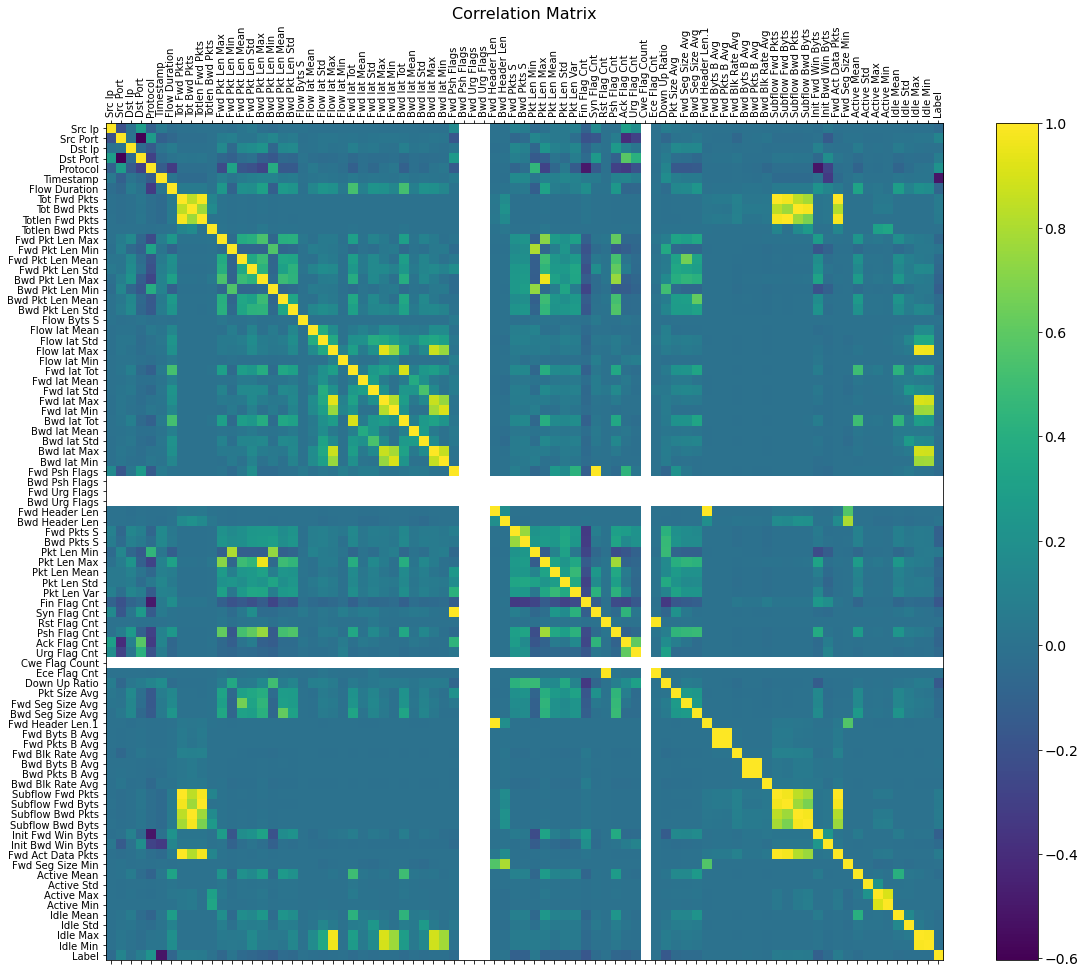

In [15]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

La heatmap descrive la matrice di correlazione e guardandola si nota che ci sono alcune coppie di features che correlano tra di loro anche con valori molto alti (zone in giallo, esclusa la diagonale, e verde), perciò ha senso calcolare la PCA.

Una particolarità della matrice di correlazione qui sopra è il fatto che ci sono dei valori NaN o comunque non si è riuscite a calcolare la correlazione tra le features. Le features da tenere in considerazione sono: *Bwd Psh Flags*, *Fwd Urg Flags*, *Bwd Urg Flags* e *Cwe Flag Count*.

In [23]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory= False)

FileNotFoundError: [Errno 2] No such file or directory: '../csv/dataset.csv'

In [26]:
cm = dataset.corr()

cm.loc[:, ['Bwd Psh Flags','Fwd Urg Flags', 'Bwd Urg Flags', 'Cwe Flag Count']]

/var/folders/4y/z5w7pprd3bxb9r0f1rrcqmw80000gn/T/ipykernel_13908/826307376.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = dataset.corr()


,Bwd Psh Flags,Fwd Urg Flags,Bwd Urg Flags,Cwe Flag Count
Src Ip,NaN,NaN,NaN,NaN
Src Port,NaN,NaN,NaN,NaN
Dst Ip,NaN,NaN,NaN,NaN
Dst Port,NaN,NaN,NaN,NaN
Protocol,NaN,NaN,NaN,NaN
...,...,...,...,...
Idle Mean,NaN,NaN,NaN,NaN
Idle Std,NaN,NaN,NaN,NaN
Idle Max,NaN,NaN,NaN,NaN
Idle Min,NaN,NaN,NaN,NaN


Perché ciò accade?
Per rispondere alla domanda come prima cosa andiamo ad analizzare i valori presi per le features sopra citate

In [27]:
dataset.loc[:, ['Bwd Psh Flags','Fwd Urg Flags', 'Bwd Urg Flags', 'Cwe Flag Count']]

,Bwd Psh Flags,Fwd Urg Flags,Bwd Urg Flags,Cwe Flag Count
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1686927,0,0,0,0
1686928,0,0,0,0
1686929,0,0,0,0
1686930,0,0,0,0


In [28]:
for col in ['Bwd Psh Flags','Fwd Urg Flags', 'Bwd Urg Flags', 'Cwe Flag Count']:
    print(f"{col} -> {np.unique(dataset.loc[:, col])}")

Bwd Psh Flags -> [0]
Fwd Urg Flags -> [0]
Bwd Urg Flags -> [0]
Cwe Flag Count -> [0]


Utilizzando come coefficiente di correlazione il **coeficiete di Pearson** e dividendo il tutto per 0 e ciò è matematicamente impossibile, quindi per questo motivo il coefficiente di correlazione tra le features sopracitate e le altre non è calcolabile.

Da queste osservazioni si può concludere che *Bwd Psh Flags*, *Fwd Urg Flags*, *Bwd Urg Flags* e *Cwe Flag Count* non influenzano il modello e di conseguenza neanche le previsioni fatte da esso perciò tali features le posso andare a cancellare dal dataset.
Ciò è dovuto dal fatto che questi campi fanno riferimento a dei flag contenuti nel header TCP e vengono usati per generare particolari tipologie di traffico che non vengono sfruttate.

In [29]:
dataset.drop(['Bwd Psh Flags','Fwd Urg Flags', 'Bwd Urg Flags', 'Cwe Flag Count'], inplace=True, axis=1)

dataset.to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

Prima di effettuare la PCA necessito di andare a standardizzare i dati

In [31]:
def feature_extraction(data, n_components, norm=False):
    if norm:
        scalar = StandardScaler()
        scalar.fit(data)
        data = scalar.transform(data)

    pca = PCA(n_components)

    pca.fit(data)

    #X_train = pca.transform(X_train)
    #X_test = pca.transform(X_test)

    return pca

In [32]:
X, y = dataset.loc[:, 'Src Ip' : 'Idle Min'], dataset.loc[:, 'Label']

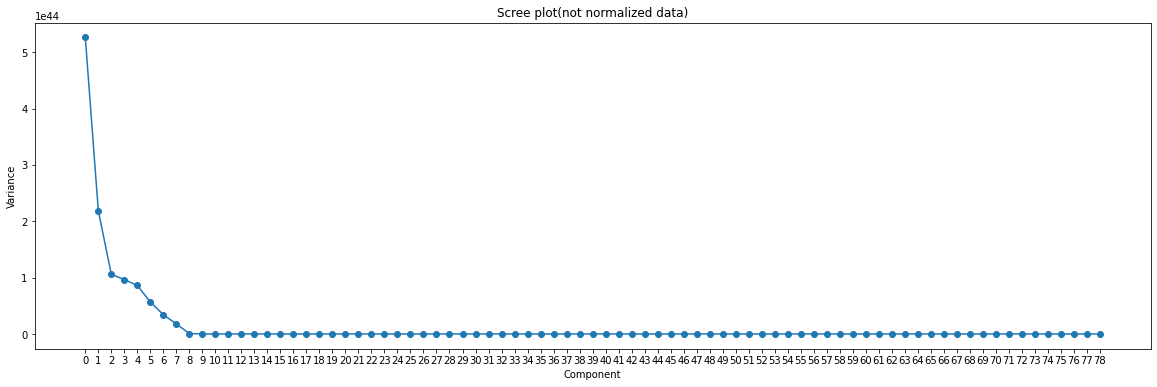

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, train_size=.8)

#X_train = scalar.transform(X_train)
#X_test = scalar.transform(X_test)
pca = feature_extraction(X, X.shape[1], False)

plt.figure(figsize=(20, 6))
plt.plot(range(pca.n_components_), pca.explained_variance_)
plt.scatter(range(pca.n_components_), pca.explained_variance_)
plt.title("Scree plot(not normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca.n_components_), range(pca.n_components_))
plt.ylabel("Variance")
plt.show()

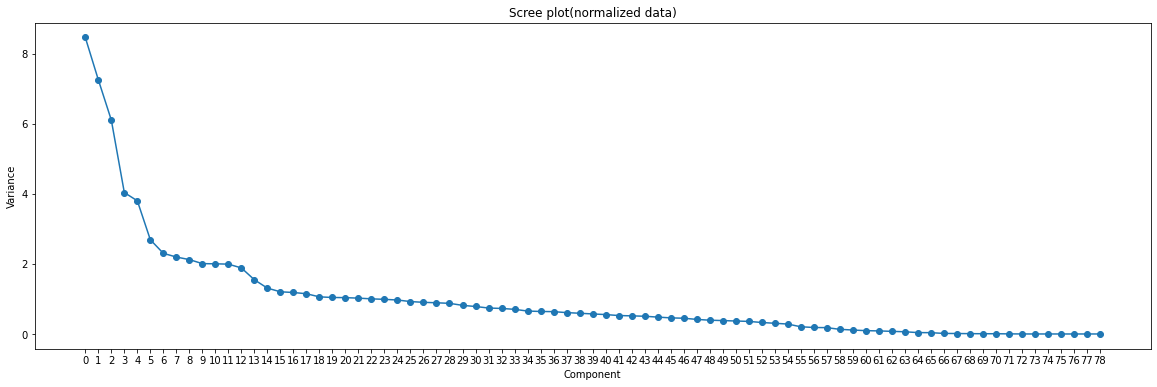

In [34]:
pca_norm = feature_extraction(X, X.shape[1], True)

plt.figure(figsize=(20, 6))
plt.plot(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.scatter(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.title("Scree plot(normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca_norm.n_components_), range(pca_norm.n_components_))
plt.ylabel("Variance")
plt.show()

Dai grafici presentati del caso di dati non normalizzati si andrebbero a estrarre **6/7 features**, oppure nel caso di dati normalizzati ado a estrarre **dalle 13 alle 57 features**.

Per trovare con maggior precisione il numero di features attraverso la **regola di Kaiser** in cui si tengono solo le componenti che hanno un valore della varianza(autovalori) non sia **inferiore a 1 oppure a 0.7**. In letteratura la primo valore risulta troppo alto.

In [35]:
print("Threshold 1")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > 1])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > 1])} features")

Threshold 1
Regola di Kaiser su dati non normalizzati: 79 features
Regola di Kaiser su dati normalizzati: 23 features


In [36]:
print("Threshold 0.7")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > .7])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > .7])} features")

Threshold 0.7
Regola di Kaiser su dati non normalizzati: 79 features
Regola di Kaiser su dati normalizzati: 34 features


In linea di massima da come si è visto dai risultati sopra la regola di Kaiser funziona solo su **dati normalizzati**, ottenedo un totale di 23 o 34 featiures rispettivamete nel caso in cui il threshold sia 1 o 0.7. Così facendo si riduce del **72%**(23 features) o del **59%**(34 features).

I risultati descritti sopra soddisfano la condizione descritta dai grafici ottenuta analizzando l'andamento dei grafici vedendo dove avviene la suddivisone tra autovalori "grandi" e "piccoli" che viene contrassegnato da un "gomito".

# BILANCIAMENTO DATASET

Prima di tutto voglio andare a vedere come le due classi sono distribuite all'interno del dataset

In [21]:
labels, counts = np.unique(dataset['Label'], return_counts=True)

print(labels)
print(counts)

[0. 1.]
[1592331   94601]


Si vede che la classe *BENIGN*, contrassegnato con lo 0, è quella maggiormente presente con un totale di 1592331 records contro i 94601 dei recods malevoli

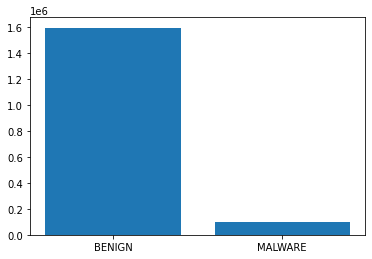

In [22]:
labels = np.where(labels == 0., "BENIGN", "MALWARE")

plt.bar(labels, counts)
plt.show()

Le tecniche che vorrei utilizzare per bilanciare il dataset sono principalmente 2: sfruttare la **focal loss** o la **SMOTE** (Synthetic Minority Oversampling Technique).

In [23]:
del dataset

# ADDESTRAMENTO DEL MODELLO

Prima di addestrare i modelli andiamo a dividere il dataset in training e test set e li memorizzo su file

In [37]:
data = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)
X, y = data.loc[:, 'Src Ip' : 'Idle Min'], data.loc[:, 'Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, train_size=.7)

print("Lettura completata")

Lettura completata


In [38]:
training_set, test_set =  X_train, X_test

training_set['Label'] = y_train
test_set['Label'] = y_test

#print(test_set)
training_set.to_csv(f"{DATASET_PATH}/train.csv", index=False)
test_set.to_csv(f"{DATASET_PATH}/test.csv", index=False)

I modelli che andremo a sfruttare sono i seguenti: **Decision Tree**, **Random Forest** e **Neural Tree**.

I modelli saranno addestati con le seguenti modallità, per poi andarli a confrontare provando a determinare quali siano le migliori features atte a rilevare un attacco ransomware analizzando il traffico.

Le modalità di addestramento saranno le seguenti:
* con dataset sbilanciato
* dataset bilanciato

Queste due modalità verranno ripetute sia su dataset con tutte le features e sia dopo una fase di features reduction.

In [8]:
top_10 = ['Protocol', 'Bwd Header Len', 'Flow Iat Max', 'Bwd Pkts S', 'Flow Byts S', 'Timestamp', 'Flow Pkts S', 'Fwd Pkts S', 'Flow Duration', 'Src Ip']
top_20 = ['Pkt Len Var', 'Subflow Fwd Byts', 'Totlen Bwd Pkts', 'Pkt Len Std', 'Fwd Header Len.1', 'Fwd Seg Size Min', 'Tot Bwd Pkts', 'Fwd Iat Max', 'Fwd Header Len', 'Bwd Pkt Len Max', 'Protocol', 'Bwd Header Len', 'Flow Iat Max', 'Bwd Pkts S', 'Flow Byts S', 'Timestamp', 'Flow Pkts S', 'Fwd Pkts S', 'Flow Duration', 'Src Ip']
top_30 = ['Fwd Pkt Len Min', 'Dst Port', 'Flow Iat Mean', 'Pkt Len Min', 'Bwd Pkt Len Min', 'Dst Ip', 'Bwd Seg Size Avg', 'Subflow Bwd Byts', 'Bwd Pkt Len Mean', 'Fwd Iat Mean', 'Pkt Len Var', 'Subflow Fwd Byts', 'Totlen Bwd Pkts', 'Pkt Len Std', 'Fwd Header Len.1', 'Fwd Seg Size Min', 'Tot Bwd Pkts', 'Fwd Iat Max', 'Fwd Header Len', 'Bwd Pkt Len Max', 'Protocol', 'Bwd Header Len', 'Flow Iat Max', 'Bwd Pkts S', 'Flow Byts S', 'Timestamp', 'Flow Pkts S', 'Fwd Pkts S', 'Flow Duration', 'Src Ip']

In [63]:
training_set = pd.read_csv(f"{DATASET_PATH}/train.csv", low_memory=False)
test_set = pd.read_csv(f"{DATASET_PATH}/test.csv", low_memory=False)

X_train, y_train = training_set[top_30].to_numpy(), training_set.loc[:, 'Label'].to_numpy()
X_test, y_test = test_set[top_30].to_numpy(), test_set.loc[:, 'Label'].to_numpy()
#X_train, y_train = training_set.loc[:, 'Src Ip' : 'Idle Min'].to_numpy(), training_set.loc[:, 'Label'].to_numpy()
#X_test, y_test = test_set.loc[:, 'Src Ip' : 'Idle Min'].to_numpy(), test_set.loc[:, 'Label'].to_numpy()

print("DATASET ACQUISITI")

del training_set, test_set

DATASET ACQUISITI


In [9]:
oversample = SMOTE()

In [27]:
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test, y_test)

print("Bilanciamento completato")

Bilanciamento completato


In [28]:
train_balanced = X_train_balanced
train_balanced['Label'] = y_train_balanced

test_balanced = X_test_balanced
test_balanced['Label'] = y_test_balanced

train_balanced.to_csv(f"{DATASET_PATH}/balanced_train.csv")
test_balanced.to_csv(f"{DATASET_PATH}/balanced_test.csv")

In [64]:
training_set_balanced = pd.read_csv(f"{DATASET_PATH}/balanced_train.csv", low_memory=False)
test_set_balanced = pd.read_csv(f"{DATASET_PATH}/balanced_test.csv", low_memory=False)

X_train_balanced, y_train_balanced = training_set_balanced[top_30].to_numpy(), \
                                        training_set_balanced.loc[:, 'Label'].to_numpy()
X_test_balanced, y_test_balanced = test_set_balanced[top_30].to_numpy(), \
                                        test_set_balanced.loc[:, 'Label'].to_numpy()
#X_train_balanced, y_train_balanced = training_set_balanced.loc[:, 'Src Ip' : 'Idle Min'].to_numpy(), \
 #                                       training_set_balanced.loc[:, 'Label'].to_numpy()
#X_test_balanced, y_test_balanced = test_set_balanced.loc[:, 'Src Ip' : 'Idle Min'].to_numpy(), \
 #                                       test_set_balanced.loc[:, 'Label'].to_numpy()

print("DATASET BILANCIATI ACQUISITI")

del training_set_balanced, test_set_balanced

DATASET BILANCIATI ACQUISITI


## DECISION TREE

### DATASET SBILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/dt_unbalance10.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/dt_unbalance.pkl")

        dt_model = pkl.load(file)
except IOError:
    dt = DecisionTreeClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    dt_model = dt.fit(X_train, y_train)

    print(f"L'addestramento del decision tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/dt_unbalance30.pkl")
    with open(f"{EXPORTED_MODEL}/dt_unbalance30.pkl", 'wb') as file:
        pkl.dump(dt_model, file)

Visualizziamo il decision tree

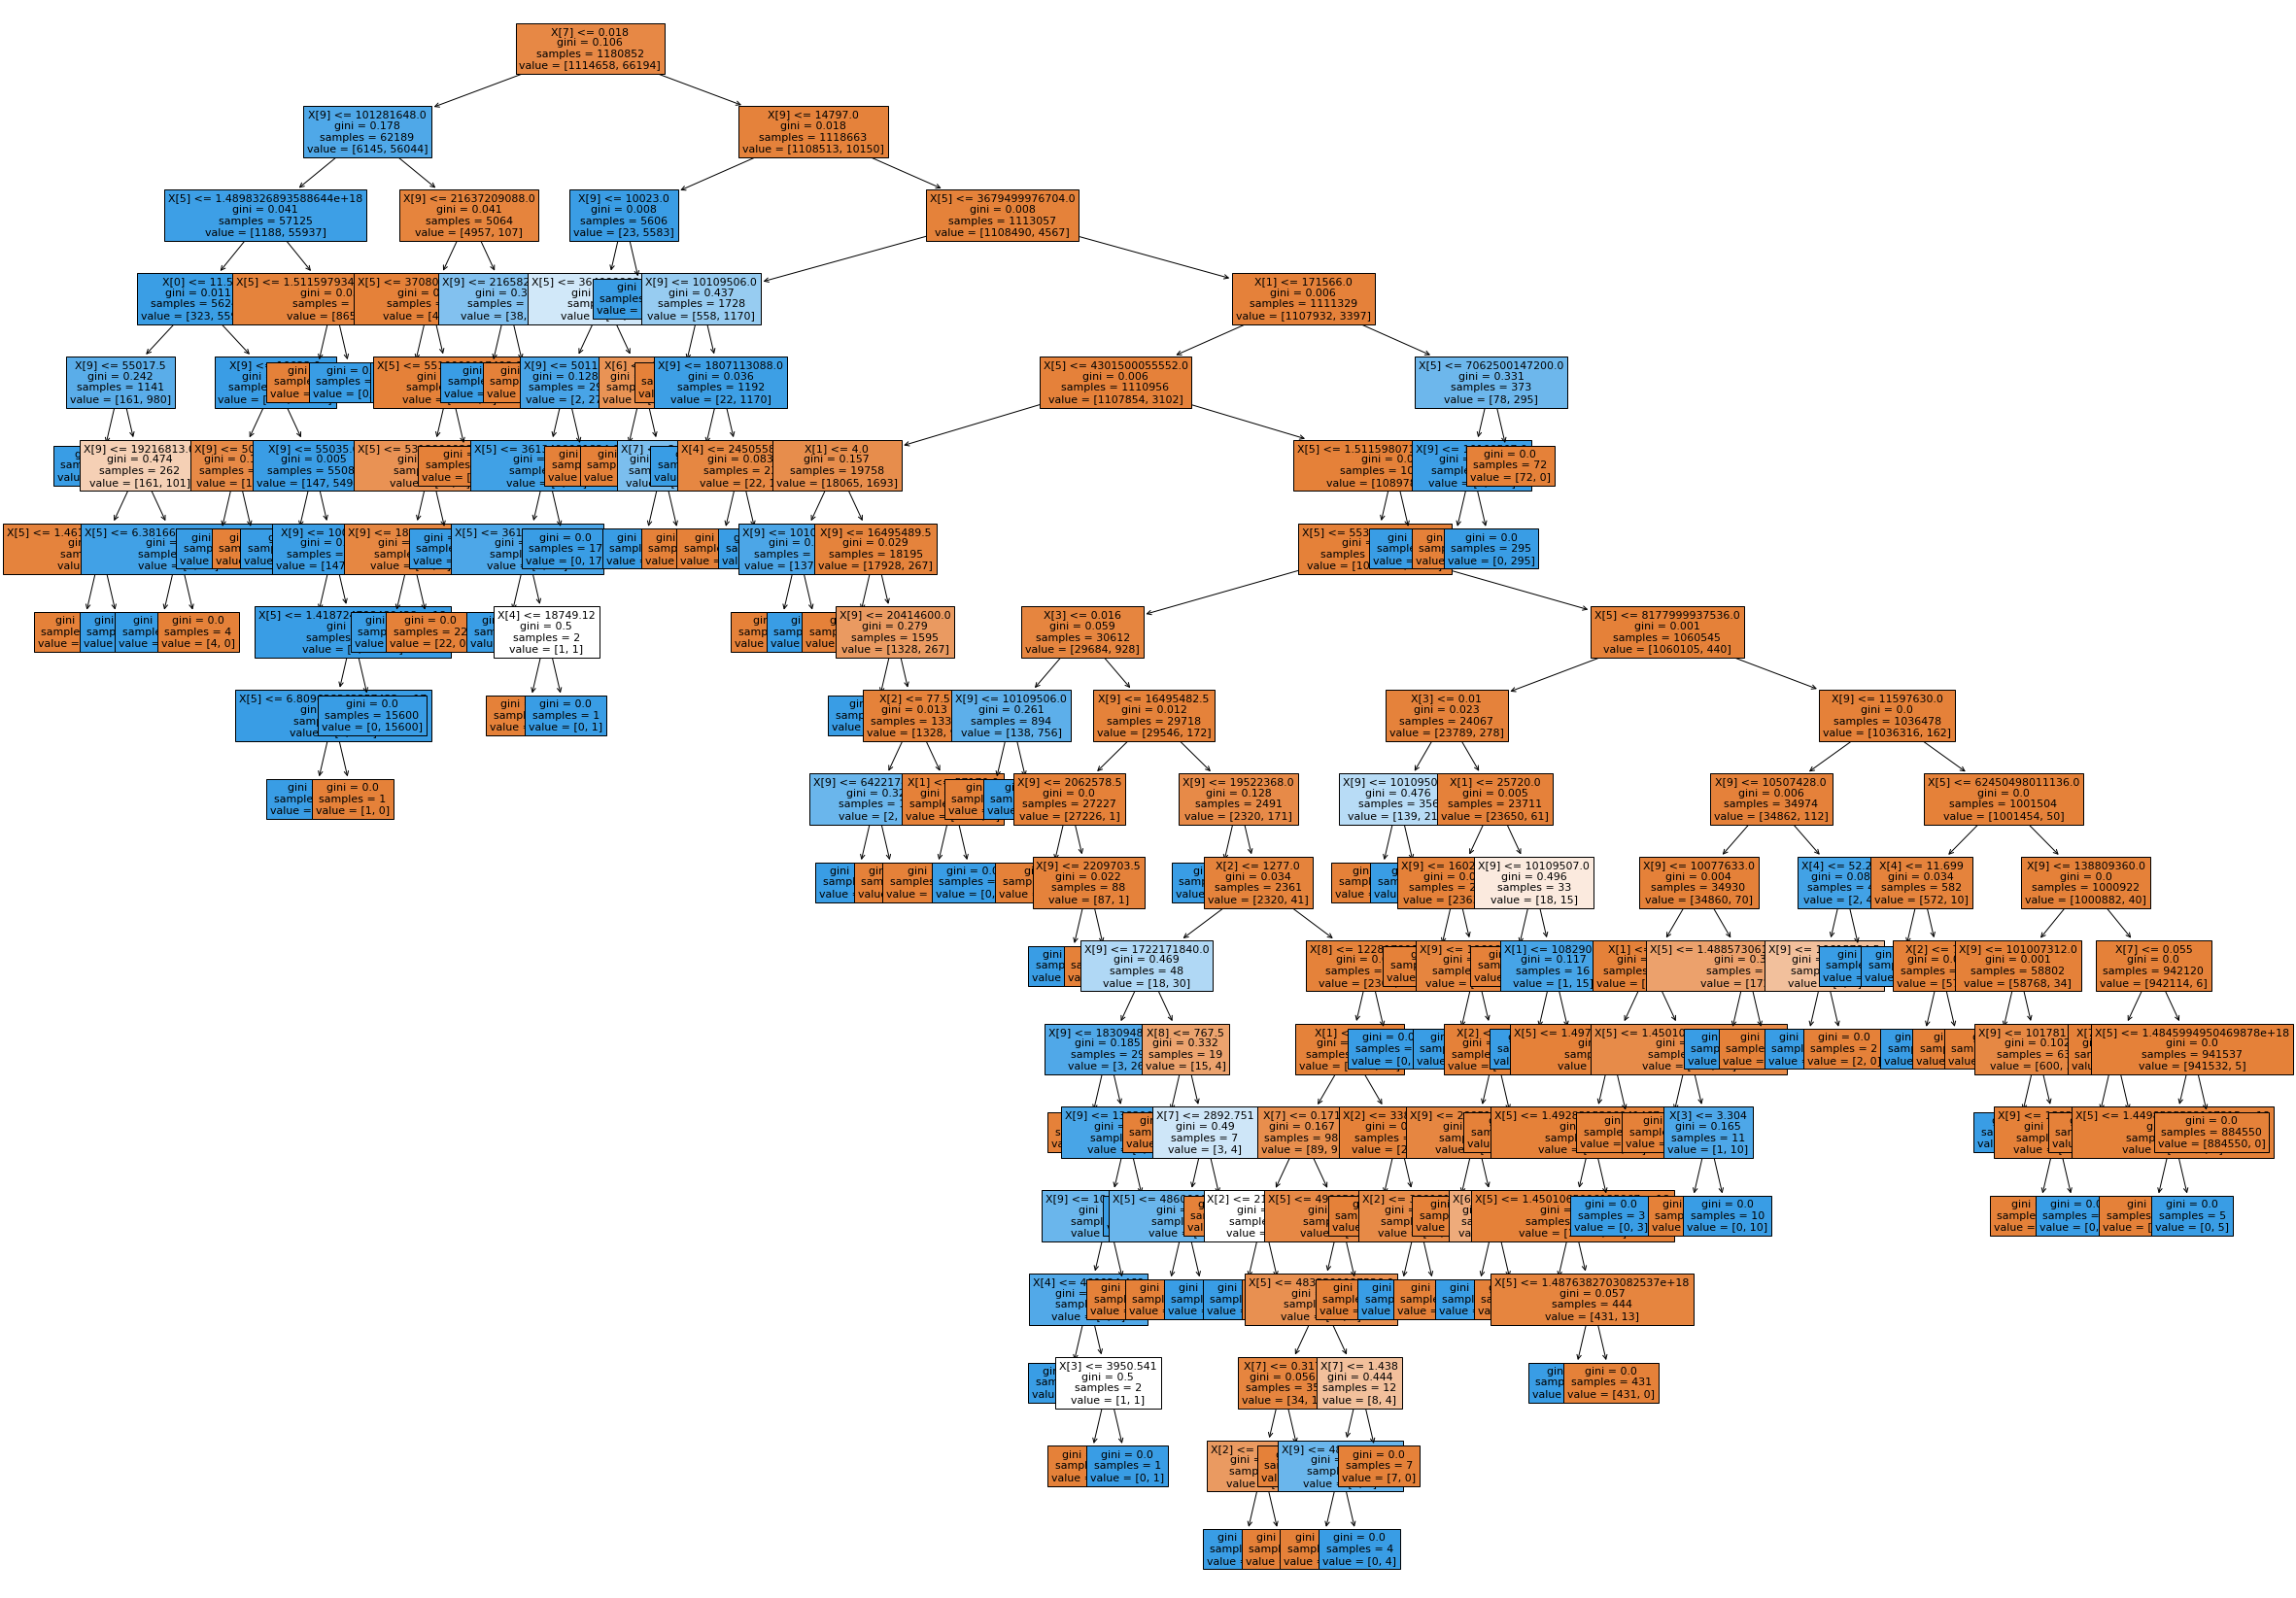

In [23]:
plt.figure(figsize=(40,30))
plot_tree(dt_model, filled=True, fontsize=11)
plt.show()

### DATASET BILANCIATO

In [25]:
try:
    with open(f"{EXPORTED_MODEL}/dt_balance10.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/dt_balance30.pkl")

        dt_balance_model = pkl.load(file)
except IOError:
    dt = DecisionTreeClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    dt_balance_model = dt.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento del decision tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/dt_balance30.pkl")
    with open(f"{EXPORTED_MODEL}/dt_balance30.pkl", 'wb') as file:
        pkl.dump(dt_balance_model, file)

CARICAMENTO MODELLO DA ../exported_model/dt_balance30.pkl


Visualizzo il decision tree

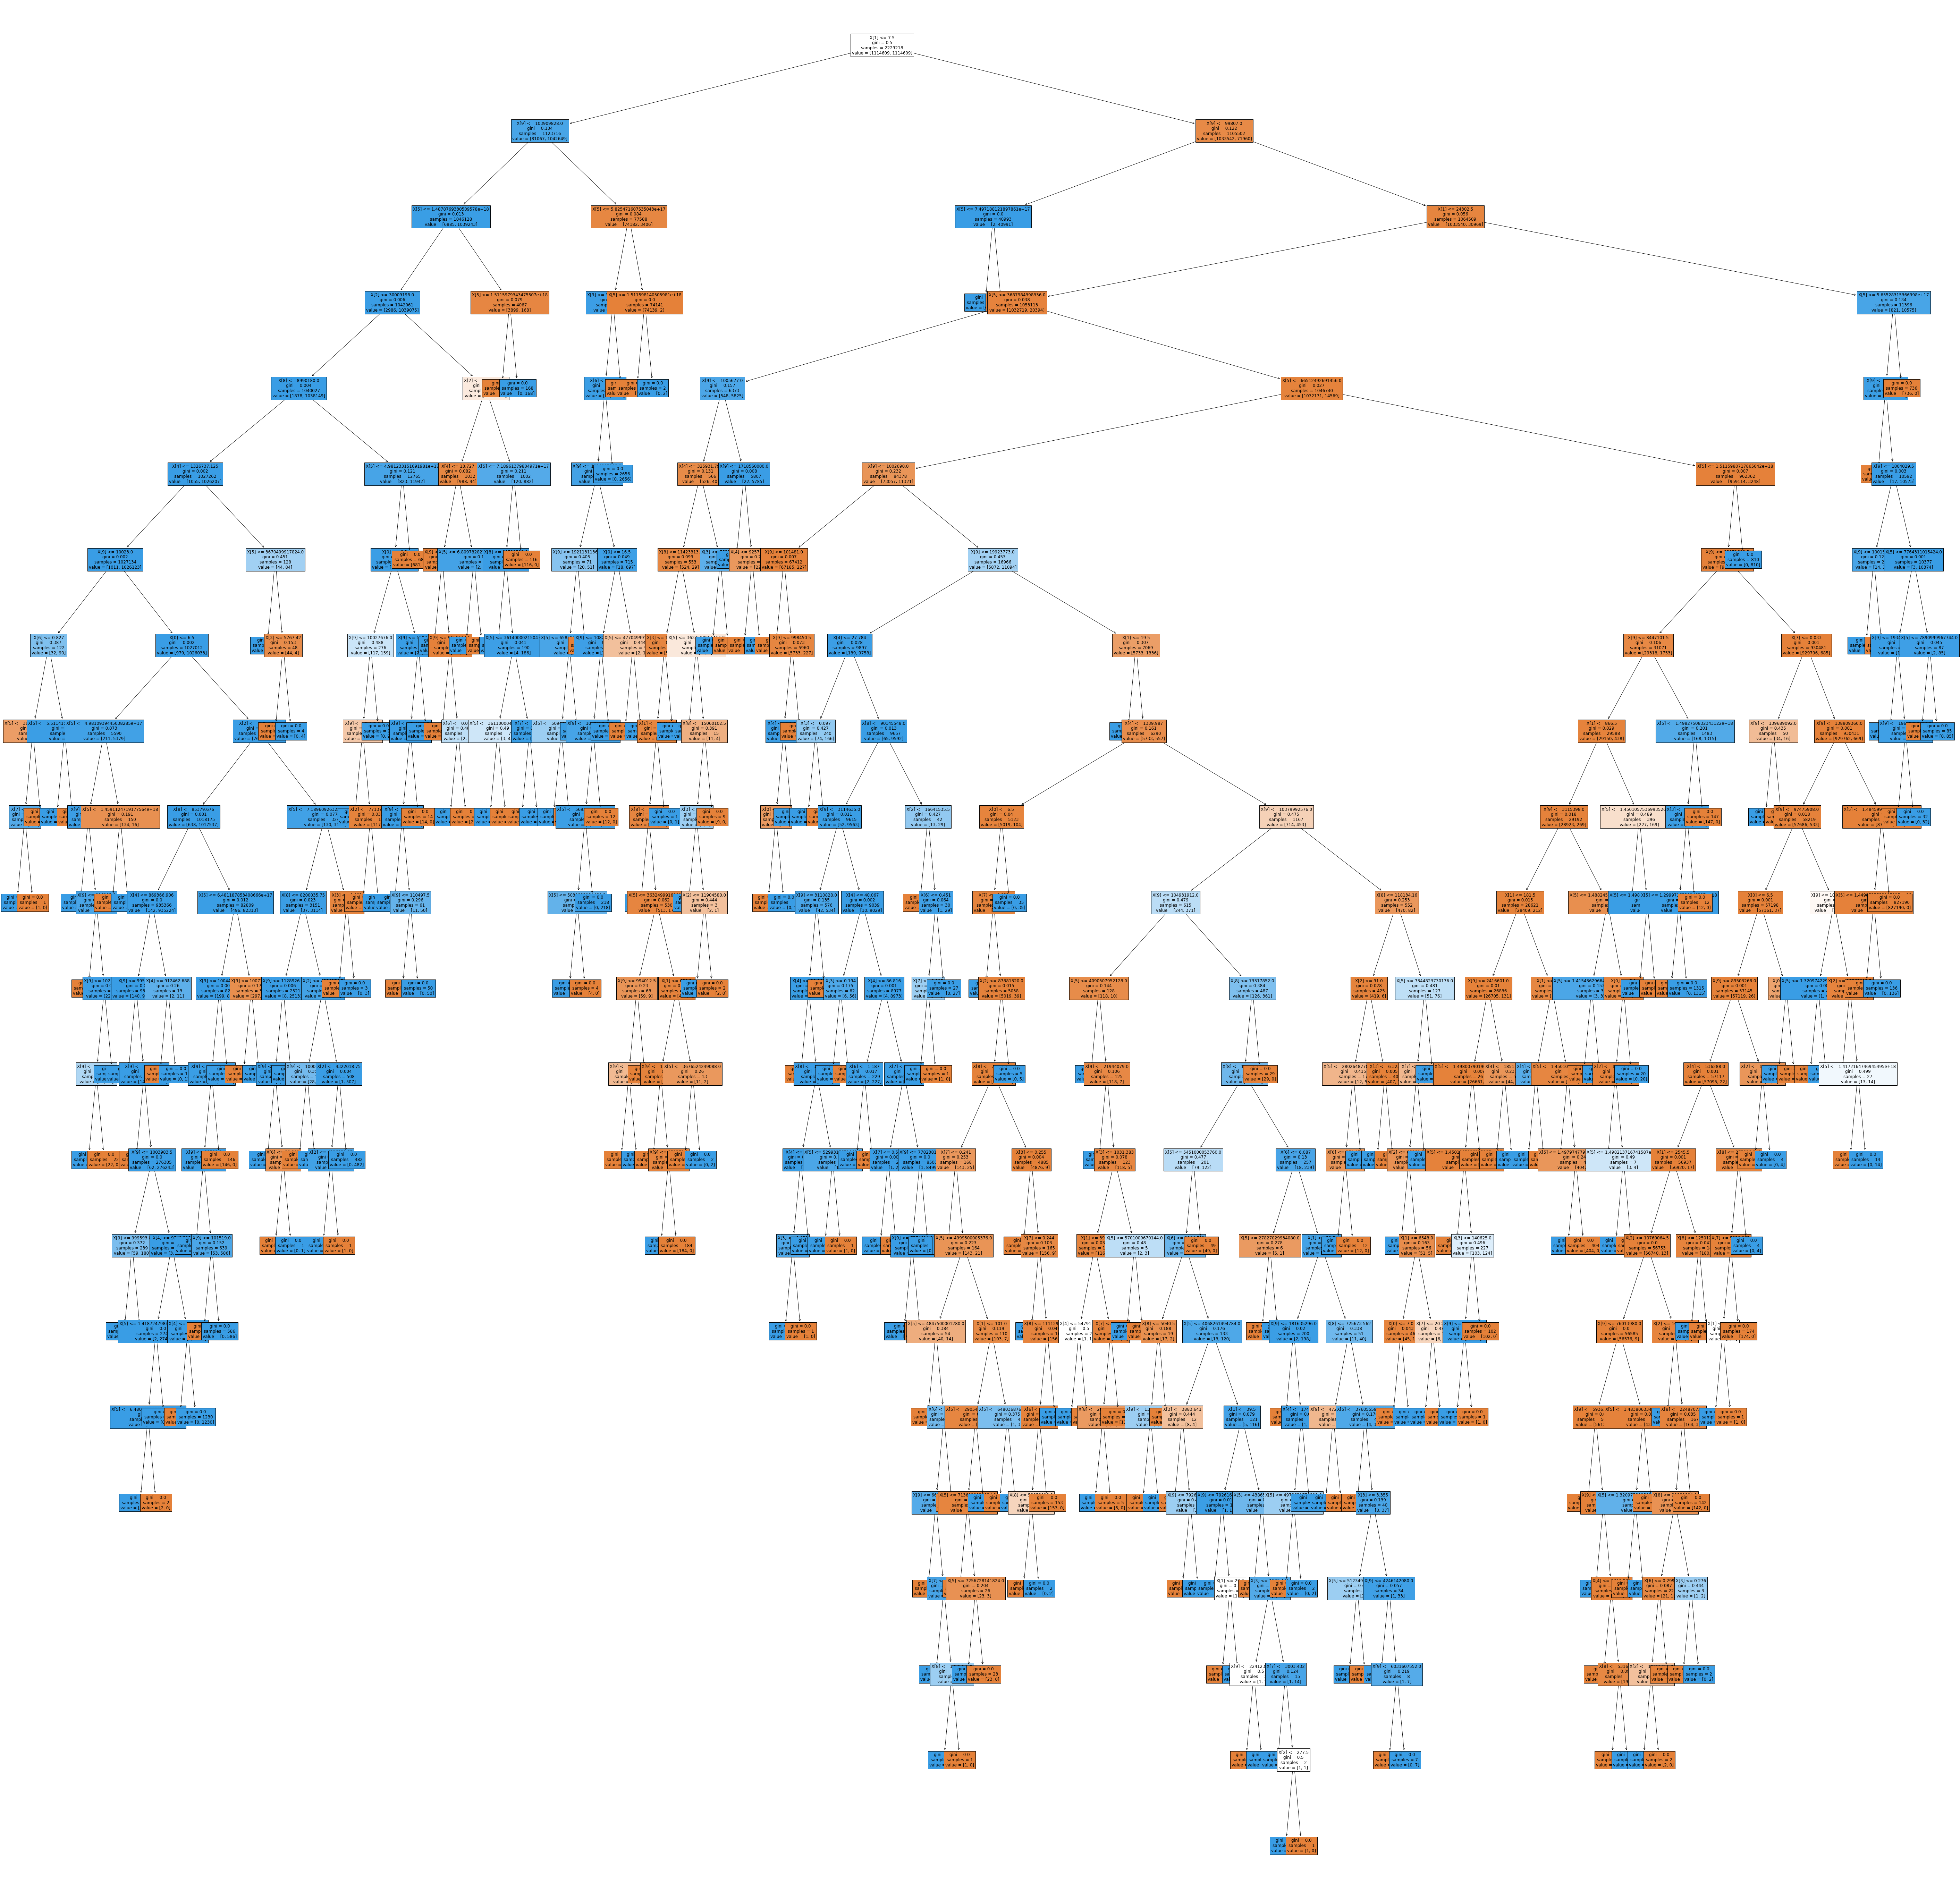

In [30]:
plt.figure(figsize=(100,100))
plot_tree(dt_balance_model, filled=True, fontsize=12)
plt.show()

## RANDOM FOREST

### DATASET SBILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/rf_unbalance30.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/rf_unbalance30.pkl")

        rf_model = pkl.load(file)
except IOError:
    rf = RandomForestClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO RANDOM FOREST")
    rf_model = rf.fit(X_train, y_train)

    print(f"L'addestramento della random forest ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/rf_unbalance30.pkl")
    with open(f"{EXPORTED_MODEL}/rf_unbalance30.pkl", 'wb') as file:
        pkl.dump(rf_model, file)

Visualizza la random forest

In [ ]:
index = 0
fig, axes = plt.subplots(nrows = 10,ncols = 5,figsize = (10, 10), dpi=900)

for tree in rf_model.estimators_:
    plot_tree(tree)

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
    index += 1

### VALUTAZIONE MODELLO

In [ ]:
print(f"Precision in training phase: {rf_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {rf_model.score(X_test, y_test)}")

### DATASET BILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/rf_balance30.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/rf_balance30.pkl")

        rf_balance_model = pkl.load(file)
except IOError:
    rf = RandomForestClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO RANDOM FOREST")
    rf_balance_model = rf.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della random forest ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/rf_balance30.pkl")
    with open(f"{EXPORTED_MODEL}/rf_balance30.pkl", 'wb') as file:
        pkl.dump(rf_balance_model, file)

Visualizza la random forest

In [ ]:
for tree in rf_balance_model.estimators:
    tree.plot_tree(tree)

### VALUTAZIONE MODELLO

In [28]:
print(f"Precision in training phase: {rf_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {rf_balance_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {rf_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 1.0
Precision in testing phase(unbalance): 0.999905153335441
Precision in testing phase(balance): 0.9999173159285107


## K NEAREST NEIGHBORS

### DATASET SBILANCIATO

In [221]:
try:
    with open(f"{EXPORTED_MODEL}/knn_unbalance30.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/knn_unbalance30.pkl")

        knn_model = pkl.load(file)
except IOError:
    knn = KNeighborsClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO K NEAREST NEIGHBOR")
    knn_model = knn.fit(X_train, y_train)

    print(f"L'addestramento de k nearest neighbors ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/knn_unbalance30.pkl")
    with open(f"{EXPORTED_MODEL}/knn_unbalance30.pkl", 'wb') as file:
        pkl.dump(knn_model, file)

INIZIO ADDESTRAMENTO K NEAREST NEIGHBOR
L'addestramento de k nearest neighbors ha impiegato 0.15834593772888184 secondi
SALVATAGGIO MODELLO IN ../exported_model/knn_unbalance30.pkl


#### VALUTAZIONE MODELLO

In [45]:
print(f"Precision in training phase: {knn_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {knn_model.score(X_test, y_test)}")

Precision in training phase: 0.996160399440404
Precision in testing phase: 0.9944593740120139


### DATASET BILANCIATO

In [19]:
try:
    with open(f"{EXPORTED_MODEL}/knn_balance30.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/knn_balance30.pkl")

        knn_balance_model = pkl.load(file)
except IOError:
    knn = KNeighborsClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO K NEAREST NEIGHBORS")
    knn_balance_model = knn.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento de k nearest neighbors ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/knn_balance30.pkl")
    with open(f"{EXPORTED_MODEL}/knn_balance30.pkl", 'wb') as file:
        pkl.dump(knn_balance_model, file)

INIZIO ADDESTRAMENTO K NEAREST NEIGHBORS
L'addestramento de k nearest neighbors ha impiegato 1.2690203189849854 secondi
SALVATAGGIO MODELLO IN ../exported_model/knn_balance.pkl


#### VALUTAZIONE MODELLO

In [10]:
print(f"Precision in training phase: {knn_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {knn_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {knn_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 0.9960039798709682
Precision in testing phase(balance): 0.9859615006217005


In [ ]:
del dt, dt_model, dt_balance_model, rf, rf_model, rf_balance_model, knn, knn_model, knn_balance_model

## NEURAL TREE

### DATASET SBILANCIATO

In [ ]:
train = pd.read_csv(f"{DATASET_PATH}/train.csv")[np.append(top_10, 'Label')].to_numpy()
#train = pd.read_csv(f"{DATASET_PATH}/train.csv").to_numpy()

try:
    with open(f"{EXPORTED_MODEL}/nt_unbalance10.pkl", 'rb') as _:
        print("CARICAMENTO MODELLO DA ../exported_model/nt_unbalance10.pkl")

        nt = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_unbalance10.pkl")
except IOError:
    labels, counts = np.unique(train[:, train.shape[1] - 1], return_counts=True)
    probs = counts / train.shape[0]

    nt = NeuralTree(entropy(probs, base=2), train.shape[1] - 1, train.shape[0], 5)
    del probs, labels, counts

    start_time = time.time()

    print("INIZIO ADDESTRAMENTO NEURAL TREE")
    nt.train(train, 250, 1)

    print(f"L'addestramento del Neural Tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/nt_unbalance10.pkl\n")
    nt.save_model(f"{EXPORTED_MODEL}/nt_unbalance10.pkl")
finally:
    nt.tree_statistic()

### DATASET BILANCIATO

In [ ]:
train = pd.read_csv(f"{DATASET_PATH}/balanced_train.csv")[np.append(top_10, 'Label')].to_numpy()
#train = pd.read_csv(f"{DATASET_PATH}/balanced_train.csv").to_numpy()

try:
    with open(f"{EXPORTED_MODEL}/nt_balance10.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/nt_balance10.pkl")

        nt = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_balance10.pkl")
except IOError:
    labels, counts = np.unique(train[:, train.shape[1] - 1], return_counts=True)
    probs = counts / train.shape[0]

    nt = NeuralTree(entropy(probs, base=2), train.shape[1] - 1, train.shape[0], 5)
    del probs, labels, counts

    start_time = time.time()

    print("INIZIO ADDESTRAMENTO NEURAL TREE")
    nt.train(train, 250, 1)

    print(f"L'addestramento del Neural Tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/nt_balance10.pkl")
    nt.save_model(f"{EXPORTED_MODEL}/nt_balance10.pkl")
finally:
    nt.tree_statistic()

# VALUTAZIONE DEL MODELLO
Questa sessione è dedicata all'analisi dei risultati ottenuti dall'analisi dei modelli ottenuti

In [24]:
target_names = ['BENIGN', 'MALWARE']

## DECISION TREE

### DATASET SBILANCIATO

L'addestramento del decision tree ha impiegato 39,33 secondi.

In [74]:
with open(f"{EXPORTED_MODEL}/dt_unbalance30.pkl", 'rb') as file:
    dt = pkl.load(file)

train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)

Il modello in fase di training ha ottenuto le seguenti performance

In [75]:
print(classification_report(y_train, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114658
     MALWARE   1.000000  1.000000  1.000000     66194

    accuracy                       1.000000   1180852
   macro avg   1.000000  1.000000  1.000000   1180852
weighted avg   1.000000  1.000000  1.000000   1180852



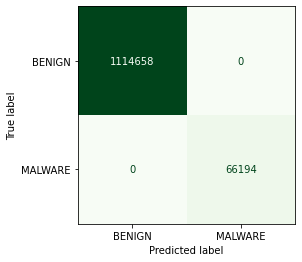

In [76]:
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [77]:
print(classification_report(y_test, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.999975  0.999962  0.999969    477673
     MALWARE   0.999366  0.999578  0.999472     28407

    accuracy                       0.999941    506080
   macro avg   0.999671  0.999770  0.999720    506080
weighted avg   0.999941  0.999941  0.999941    506080



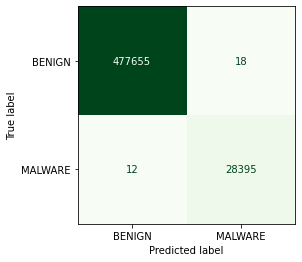

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False)

### DATASET BILANCIATO

L'addestramento del decision tree ha impiegato 51,38 secondi.

In [159]:
with open(f"{EXPORTED_MODEL}/dt_balance30.pkl", 'rb') as file:
    dt = pkl.load(file)

train_pred = dt.predict(X_train_balanced)
test_pred = dt.predict(X_test_balanced)

Il modello in fase di training ha ottenuto le seguenti performance

In [160]:
print(classification_report(y_train_balanced, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114609
     MALWARE   1.000000  1.000000  1.000000   1114609

    accuracy                       1.000000   2229218
   macro avg   1.000000  1.000000  1.000000   2229218
weighted avg   1.000000  1.000000  1.000000   2229218



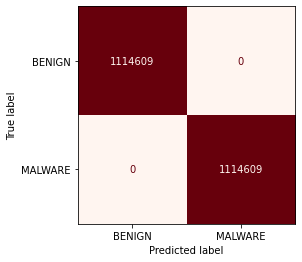

In [161]:
ConfusionMatrixDisplay(confusion_matrix(y_train_balanced, train_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [162]:
print(classification_report(y_test_balanced, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.999724  0.999948  0.999836    477722
     MALWARE   0.999948  0.999724  0.999836    477722

    accuracy                       0.999836    955444
   macro avg   0.999836  0.999836  0.999836    955444
weighted avg   0.999836  0.999836  0.999836    955444



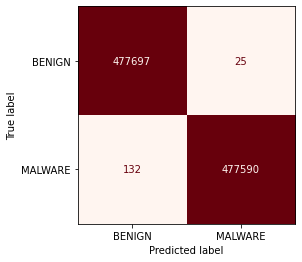

In [163]:
ConfusionMatrixDisplay(confusion_matrix(y_test_balanced, test_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False)

In [202]:
del dt

## RANDOM FOREST

### DATASET SBILANCIATO

L'addestramento della random forest ha impiegato 297,64 secondi.

In [9]:
with open(f"{EXPORTED_MODEL}/rf_unbalance30.pkl", 'rb') as file:
    rf = pkl.load(file)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

Il modello in fase di training ha ottenuto le seguenti performance

In [12]:
print(classification_report(y_train, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114658
     MALWARE   1.000000  1.000000  1.000000     66194

    accuracy                       1.000000   1180852
   macro avg   1.000000  1.000000  1.000000   1180852
weighted avg   1.000000  1.000000  1.000000   1180852



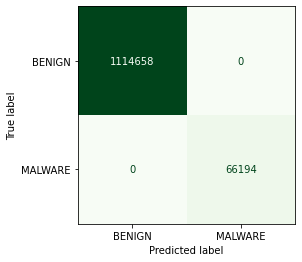

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [14]:
print(classification_report(y_test, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.999975  0.999998  0.999986    477673
     MALWARE   0.999965  0.999578  0.999771     28407

    accuracy                       0.999974    506080
   macro avg   0.999970  0.999788  0.999879    506080
weighted avg   0.999974  0.999974  0.999974    506080



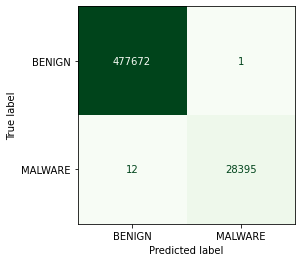

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False)

### DATASET BILANCIATO

L'addestramento della random forest ha impiegato 447,96 secondi.

In [203]:
with open(f"{EXPORTED_MODEL}/rf_balance30.pkl", 'rb') as file:
    rf = pkl.load(file)

train_pred = rf.predict(X_train_balanced)
test_pred = rf.predict(X_test_balanced)

Il modello in fase di training ha ottenuto le seguenti performance

In [204]:
print(classification_report(y_train_balanced, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114609
     MALWARE   1.000000  1.000000  1.000000   1114609

    accuracy                       1.000000   2229218
   macro avg   1.000000  1.000000  1.000000   2229218
weighted avg   1.000000  1.000000  1.000000   2229218



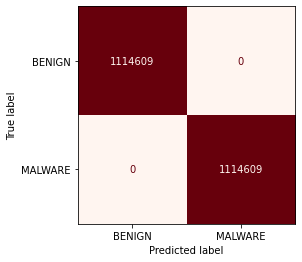

In [205]:
ConfusionMatrixDisplay(confusion_matrix(y_train_balanced, train_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [206]:
print(classification_report(y_test_balanced, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.999891  0.999950  0.999920    477722
     MALWARE   0.999950  0.999891  0.999920    477722

    accuracy                       0.999920    955444
   macro avg   0.999920  0.999920  0.999920    955444
weighted avg   0.999920  0.999920  0.999920    955444



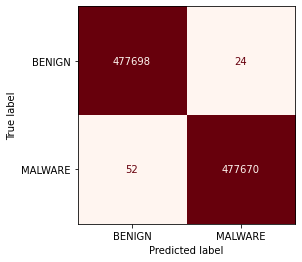

In [208]:
ConfusionMatrixDisplay(confusion_matrix(y_test_balanced, test_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False)

In [72]:
del rf

## K NEAREST NEIGHBORS

### DATASET SBILANCIATO

L'addestramento della knn ha impiegato 1,49 secondi.

In [61]:
with open(f"{EXPORTED_MODEL}/knn_unbalance.pkl", 'rb') as file:
    knn = pkl.load(file)

train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

Predizione completata
Predizione completata


Il modello in fase di training ha ottenuto le seguenti performance

In [62]:
print(classification_report(y_train, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.997658  0.998214  0.997936   1114658
     MALWARE   0.969637  0.960540  0.965067     66194

    accuracy                       0.996102   1180852
   macro avg   0.983647  0.979377  0.981501   1180852
weighted avg   0.996087  0.996102  0.996093   1180852



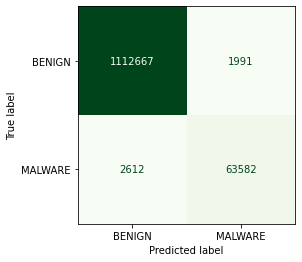

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [64]:
print(classification_report(y_test, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.997009  0.997341  0.997175    477673
     MALWARE   0.955041  0.949695  0.952361     28407

    accuracy                       0.994667    506080
   macro avg   0.976025  0.973518  0.974768    506080
weighted avg   0.994654  0.994667  0.994660    506080



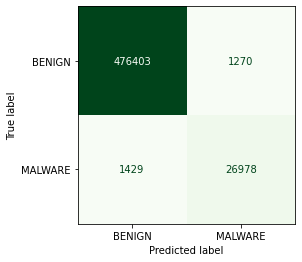

In [65]:
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False)

### DATASET BILANCIATO

L'addestramento della knn ha impiegato 1,19 secondi.

In [53]:
with open(f"{EXPORTED_MODEL}/knn_balance.pkl", 'rb') as file:
    knn = pkl.load(file)

train_pred = knn.predict(X_train_balanced)
test_pred = knn.predict(X_test_balanced)

predizione completata
predizione completata


Il modello in fase di training ha ottenuto le seguenti performance

In [54]:
print(classification_report(y_train_balanced, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.997860  0.994140  0.995997   1114609
     MALWARE   0.994161  0.997868  0.996011   1114609

    accuracy                       0.996004   2229218
   macro avg   0.996011  0.996004  0.996004   2229218
weighted avg   0.996011  0.996004  0.996004   2229218



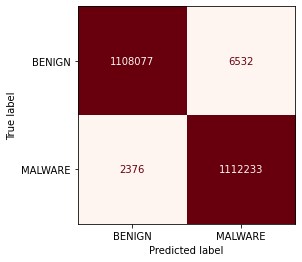

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_train_balanced, train_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False, values_format='')

Il modello in fase di testing ha ottenuto le seguenti performance

In [56]:
print(classification_report(y_test_balanced, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.980529  0.991614  0.986040    477722
     MALWARE   0.991518  0.980309  0.985882    477722

    accuracy                       0.985962    955444
   macro avg   0.986024  0.985962  0.985961    955444
weighted avg   0.986024  0.985962  0.985961    955444



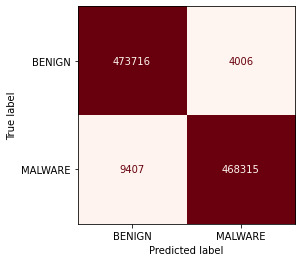

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_test_balanced, test_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False)

## NEURAL TREE

### DATASET SBILANCIATO

L'addestramento del neural tree ha impiegato *da calcolare* secondi.

In [65]:
nt = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_unbalance30.pkl")

train_pred = nt.make_predictions(X_train, verbose=1)
print("CLASSIFICAZIONE COMPLETATA")
test_pred = nt.make_predictions(X_test, verbose=1)
print("CLASSIFICAZIONE COMPLETATA")

CARICAMENTO COMPLETATO!
CLASSIFICAZIONE COMPLETATA
CLASSIFICAZIONE COMPLETATA


Il modello in fase di training ha ottenuto le seguenti performance

In [66]:
print(classification_report(y_train, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114658
     MALWARE   1.000000  1.000000  1.000000     66194

    accuracy                       1.000000   1180852
   macro avg   1.000000  1.000000  1.000000   1180852
weighted avg   1.000000  1.000000  1.000000   1180852



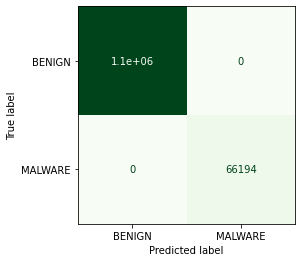

In [67]:
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False)

Il modello in fase di testing ha ottenuto le seguenti performance

In [68]:
print(classification_report(y_test, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.997613  0.997302  0.997457    477673
     MALWARE   0.954861  0.959869  0.957358     28407

    accuracy                       0.995200    506080
   macro avg   0.976237  0.978585  0.977408    506080
weighted avg   0.995213  0.995200  0.995206    506080



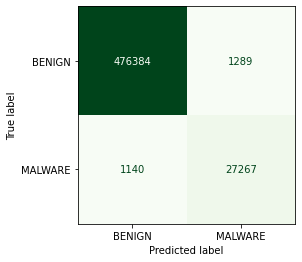

In [69]:
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred),
                       display_labels=target_names).plot(cmap="Greens", colorbar=False)

### DATASET BILANCIATO

L'addestramento del neural tree ha impiegato *da calcolare* secondi.

In [70]:
nt = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_balance30.pkl")

train_pred = nt.make_predictions(X_train_balanced, verbose=1)
print("CLASSIFICAZIONE COMPLETATA")
test_pred = nt.make_predictions(X_test_balanced, verbose=1)
print("CLASSIFICAZIONE COMPLETATA")

CARICAMENTO COMPLETATO!
CLASSIFICAZIONE COMPLETATA
CLASSIFICAZIONE COMPLETATA


Il modello in fase di training ha ottenuto le seguenti performance

In [71]:
print(classification_report(y_train_balanced, train_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   1.000000  1.000000  1.000000   1114609
     MALWARE   1.000000  1.000000  1.000000   1114609

    accuracy                       1.000000   2229218
   macro avg   1.000000  1.000000  1.000000   2229218
weighted avg   1.000000  1.000000  1.000000   2229218



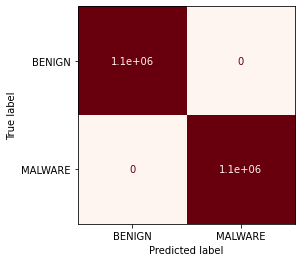

In [72]:
ConfusionMatrixDisplay(confusion_matrix(y_train_balanced, train_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False)

Il modello in fase di testing ha ottenuto le seguenti performance

In [73]:
print(classification_report(y_test_balanced, test_pred, target_names=target_names, digits=6))

              precision    recall  f1-score   support

      BENIGN   0.970133  0.995284  0.982548    477722
     MALWARE   0.995158  0.969359  0.982089    477722

    accuracy                       0.982321    955444
   macro avg   0.982646  0.982321  0.982318    955444
weighted avg   0.982646  0.982321  0.982318    955444



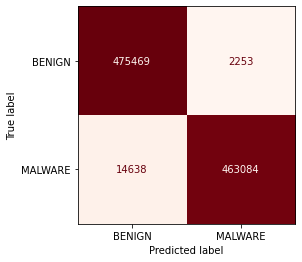

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test_balanced, test_pred),
                       display_labels=target_names).plot(cmap="Reds", colorbar=False)

# VALUTAZIONE TEMPI DI PREVISIONE

In questa sezione andremo a valutare quale degli algoritmi presi in considerazione risulta il più prestate nel momento della previsione.
Per fare ciò prendiamo in considerazione il test set e vado a calcolare la media, trovando il tempo medio per eseguire una previsione.

Questa fase viene ripetuta su dataset sbilanciato e bilanciato

## DATASET SBILANCIATO

In [75]:
data = pd.read_csv(f"{DATASET_PATH}/test.csv", low_memory=False)

X = data[top_10].to_numpy()
#X = data.loc[:, 'Src Ip' : 'Idle Min'].to_numpy()

### DECISION TREE

In [167]:
with open(f"{EXPORTED_MODEL}/dt_unbalance30.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 8.56583569949087e-08 secondi


### RANDOM FOREST

In [118]:
with open(f"{EXPORTED_MODEL}/rf_unbalance30.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 5.696425606018752e-06 secondi


### K NEAREST NEIGHBORS

In [229]:
with open(f"{EXPORTED_MODEL}/knn_unbalance30.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 0.0009289949293796902 secondi


### NEURAL TREE

In [76]:
with open(f"{EXPORTED_MODEL}/nt_unbalance10.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.make_predictions(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la classificazione per un singolo elemento, in media vale 0.00011505610979398595 secondi


## DATASET BILANCIATO

In [25]:
data = pd.read_csv(f"{DATASET_PATH}/balanced_test.csv", low_memory=False)

X = data[top_10].to_numpy()
#X = data.loc[:, 'Src Ip' : 'Idle Min'].to_numpy()

### DECISION TREE

In [165]:
with open(f"{EXPORTED_MODEL}/dt_balance30.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 8.170413590453328e-08 secondi


### RANDOM FOREST

In [210]:
with open(f"{EXPORTED_MODEL}/rf_balance30.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 5.582731167503664e-06 secondi


### K NEAREST NEIGHBORS

In [25]:
with open(f"{EXPORTED_MODEL}/knn_balance10.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.predict(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")

Il tempo impiegato per la previsione per un singolo elemento, in media vale 0.0018078827823934352 secondi


### NEURAL TREE

In [27]:
with open(f"{EXPORTED_MODEL}/nt_balance10.pkl", 'rb') as file:
    model = pkl.load(file)

start_time = time.time()

preds = model.make_predictions(X)

print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {(time.time() - start_time) / preds.shape[0]} secondi")
#print(f"Il tempo impiegato per la classificazione per un singolo elemento, in media vale {time / preds.shape[0]} secondi")

[0 1 0 ... 1 1 1]
Il tempo impiegato per la classificazione per un singolo elemento, in media vale 0.00018902412256340364 secondi


In [ ]:
del data, model